# Partial block measurements

This work is tracked in [T209403](https://phabricator.wikimedia.org/T209403).

Originally, these measurements are geared towards being run on a monthly basis, using the Data Lake as the source. Currently, partial blocks are deployed on a low number of wikis and have not been deployed for long, meaning that monthly measurements makes little sense. Secondly, data on partial blocks are not yet available in the Data Lake.

Until further notice, we'll grab the data from the replicated MediaWiki databases and explore whether daily measurements make sense.

We have the following measurements defined in our master document, defined on a monthly basis:

* Number of partial blocks for users/IPs where the block has a start timestamp within the month of interest.
* Number of partial blocks for users/IPs where the duration of the partial block intersects with the month of interest and the user/IP makes ≥1 non-reverted edits during the intersection.
* Number of partial blocks of users/IPs where:
   * The partial block has a duration intersecting with the month of interest, and the block does not have pages added during the intersection.
   * The partial block has a duration intersecting with the month of interest, and the block is not replaced by a sitewide block during the intersection.
   * The partial block has an expiry timestamp within the month of interest and the expiration timestamp is not altered to increase the duration of the partial block.

The first part of this notebook explores the first measurement, making plots of number of partial blocks set (for both registered users and IPs) per day for all wikis. Once we have data for partial blocks in the Data Lake, we'll turn these into monthly metrics.

In [1]:
## Load Python libraries

import re
import datetime as dt

import pandas as pd
import phpserialize as ps
import pymysql

from wmfdata import hive
from growth import db, utils

import mwreverts

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2);
library(data.table);
library(zoo);
library(tidyr);
library(RColorBrewer);

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [4]:
## Some configuration variables.
## Start and end timestamps allow us to speed up database queries.

start_time = dt.datetime(2019, 1, 1, 0, 0, 0)
end_time = dt.datetime(2019, 7, 22, 0, 0, 0)

## Mapping from wiki DB name to host/port information
dbhost_map = dict()

## Mapping from wiki DB name to database connection
dbconn_map = dict()

## Format strings:
## MediaWiki database timestamp format
mw_format = "%Y%m%d%H%M%S"
hive_format = "%Y-%m-%dT%H:%M:%S"


In [5]:
## See T218626 for the status of deployment of partial blocks

wikis = ['arwiki', 'metawiki', 'mediawikiwiki', 'itwiki', 'fawiki',
         'plwiki', 'frwiki', 'zhwiki', 'tewiki', 'bnwiki',
         'huwiki', 'jawiki', 'hewiki', 'srwiki', 'enwikivoyage', 'enwiktionary',
         'enwikisource', 'hewikivoyage']

In [6]:
## Some configuration:

## Dates that we will use to make plots, they'll show from start date and up to,
## but not including, the end date
start_display_date = dt.date(2019, 1, 1)
end_display_date = dt.date(2019, 7, 1)

## We'll gather data from a year prior to the start date so we can have a yearly running
## average across the whole graph
start_data_date = dt.date(start_display_date.year - 1,
                          start_display_date.month,
                          start_display_date.day)
end_data_date = end_display_date

## Some statistics require a 28-day period, so in those cases we'll truncate to the previous
## month, which we can get at with some date math (assuming that end_display_date is the
## first of the month):
truncated_end_date = (end_display_date - dt.timedelta(days = 1)).replace(day = 1)

## The name of the database snapshot we're using, which should be the year and month
## of the truncated end date
snapshot = "{}".format(truncated_end_date.strftime("%Y-%m"))

## Because rpy2 doesn't convert datetime.date objects, we'll make the display dates
## strings to help with that:
start_display_date_str = str(start_display_date)
end_display_date_str = str(end_display_date)
truncated_end_date_str = str(truncated_end_date)

## Filenames/paths to datasets that can be shared
partial_monthly_filename = "public_datasets/partial_blocks_monthly.tsv"
partial_constructive_filename = "public_datasets/partial_blocks_constructive_edits.tsv"
partial_expired_filename = "public_datasets/sitewide_expired_blocks.tsv"
partial_expired_noreblock_filename = "public_datasets/sitewide_expired_not-reblocked.tsv"
partial_expired_nonreverted_filename = "public_datasets/sitewide_expired_non-reverted.tsv"
partial_expired_nonreverted_ns0_filename = "public_datasets/sitewide_expired_non-reverted_ns0.tsv"

def to_tsv(df, output_file):
    df.to_csv(output_file, sep='\t', index=False)

In [7]:
# The second function needs dnspython to work
import dns.resolver
import glob

def get_mediawiki_section_dbname_mapping(mw_config_path, use_x1):
    db_mapping = {}
    if use_x1:
        dblist_section_paths = [mw_config_path.rstrip('/') + '/dblists/all.dblist']
    else:
        dblist_section_paths = glob.glob(mw_config_path.rstrip('/') + '/dblists/s[0-9]*.dblist')
    for dblist_section_path in dblist_section_paths:
        with open(dblist_section_path, 'r') as f:
            for db in f.readlines():
                db_mapping[db.strip()] = dblist_section_path.strip().rstrip('.dblist').split('/')[-1]

    return db_mapping


def get_dbstore_host_port(db_mapping, use_x1, dbname):
    if dbname == 'staging':
        shard = 'staging'
    elif use_x1:
        shard = 'x1'
    else:
        try:
            shard = db_mapping[dbname]
        except KeyError:
            raise RuntimeError("The database {} is not listed among the dblist files of the supported sections."
                               .format(dbname))
    answers = dns.resolver.query('_' + shard + '-analytics._tcp.eqiad.wmnet', 'SRV')
    host, port = str(answers[0].target), answers[0].port
    return (host,port)

wikidb_map = get_mediawiki_section_dbname_mapping('/srv/mediawiki-config', False)

In [8]:
for wiki in wikis:
    dbhost_map[wiki] = get_dbstore_host_port(wikidb_map, False, wiki)


In [9]:
for wiki in wikis:
    dbconn_map[wiki] = db.get_db_conn(wiki)
    

In [10]:
## Code form wmfdata to decode bytestrings returned from the database into UTF-8 strings

def try_decode(cell):
    try:
        return cell.decode(encoding = "utf-8")
    except AttributeError:
        return cell


In [11]:
def extract_params(row):
    '''
    Extract relevant block parameters from the given row of partial block log
    data, and return a new `pandas.Series` that can be used to update a data frame
    with columns for those parameters.
    '''
    params = ps.loads(row['log_params'].encode('utf-8'), decode_strings=True)
    
    try:
        duration = params['5::duration']
    except KeyError:
        duration = None
        
    try:
        flags = params['6::flags']
    except KeyError:
        flags = None

    ## Restrictions can either refer to pages or namespaces (or both, I suspect).
    ## We therefore have to check and act accordingly.
    try:     
        num_pages = 0
        num_namespaces = 0
        
        restrictions = params['7::restrictions']
        if 'pages' in restrictions:
            num_pages = len(restrictions['pages'])
            
        if 'namespaces' in restrictions:
            num_namespaces = len(restrictions['namespaces'])
    except KeyError:
        num_pages = None
        num_namespaces = None
    
    return(pd.Series([duration, flags, num_pages, num_namespaces]))

In [12]:
## SQL query to get data on partial blocks, adapted from
## https://github.com/dayllanmaza/wikireplicas-reports/blob/master/generators/partial_blocks.py

def get_partial_blocks(wikis, dbconns, start_timestamp, end_timestamp):
    pb_query = '''
    SELECT DATABASE() AS wiki,
           log_timestamp,
           log_params,
           log_user_text AS blocker,
           log_title AS blockee,
           comment_text AS reason
    FROM {wiki}.logging
    LEFT JOIN {wiki}.comment
    ON log_comment_id=comment_id
    WHERE log_timestamp >= "{start_timestamp}"
    AND log_timestamp < "{end_timestamp}"
    AND log_type = "block"
    AND log_action = "block" -- only interested in initial blocks created
    AND log_params LIKE '%"sitewide";b:0;%'
    '''
    
    pbs = []
    for wiki in wikis:
        print('getting partial blocks from {}'.format(wiki))
        df = pd.read_sql_query(
            pb_query.format(
                wiki = wiki,
                start_timestamp = start_timestamp.strftime(mw_format),
                end_timestamp = end_timestamp.strftime(mw_format)),
            dbconns[wiki])
        df = df.applymap(try_decode).rename(columns = try_decode)
        
        if len(df) == 0:
            continue
        
        ## Turn the timestamps into datetime objects, and add a log_date string for convenience
        df['log_timestamp'] = pd.to_datetime(df['log_timestamp'], format=mw_format, utc=True)
        df['log_date'] = df['log_timestamp'].apply(lambda x: str(x.date()))
        
        df[['block_duration', 'block_flags', 'block_num_pages', 'block_num_namespaces']] = df.apply(extract_params, axis=1)
        
        pbs.append(df)
    
    return(pd.concat(pbs))


In [13]:
partial_blocks = get_partial_blocks(wikis, dbconn_map, start_time, end_time)

getting partial blocks from arwiki
getting partial blocks from metawiki
getting partial blocks from mediawikiwiki
getting partial blocks from itwiki
getting partial blocks from fawiki
getting partial blocks from plwiki
getting partial blocks from frwiki
getting partial blocks from zhwiki
getting partial blocks from tewiki
getting partial blocks from bnwiki
getting partial blocks from huwiki
getting partial blocks from jawiki
getting partial blocks from hewiki
getting partial blocks from srwiki
getting partial blocks from enwikivoyage
getting partial blocks from enwiktionary
getting partial blocks from enwikisource
getting partial blocks from hewikivoyage


In [14]:
%%R -i partial_blocks

partial_blocks = data.table(partial_blocks);
partial_blocks[, log_date := as.Date(log_date)];

## Some configuration variables
graph_dir = 'graphs/';
pb_graph_prefix = 'partial_blocks_per_day_';
pb_graph_suffix = '.png';

make_pb_graphs = function(pbs, graph_dir, prefix, suffix) {
    wikis = unique(pbs$wiki);
    
    for(w in wikis) {
        ## Grab the subset for this wiki, as we have different date ranges for each
        wiki_blocks = pbs[wiki == w];
        
        ## Make a date sequence from the first to the last date, and left join against
        ## the data to fill in any dates with 0 blocks.

        dates = seq.Date(min(wiki_blocks$log_date), max(wiki_blocks$log_date), by='day');
        dates = data.table(log_date = dates);

        blocks_per_day = wiki_blocks[, list(num_blocks=sum(.N)), by=log_date];
        blocks_per_day = blocks_per_day[dates, on = 'log_date'];
        blocks_per_day[is.na(num_blocks), num_blocks := 0];

        ## Add the moving averages
        blocks_per_day[
            , num_blocks_1wma := rollapply(
                num_blocks,
                width = 7,
                FUN = mean,
                na.rm = TRUE,
                fill = 0,
                align = 'right')];
        blocks_per_day[
            , num_blocks_2wma := rollapply(
                num_blocks,
                width = 14,
                FUN = mean,
                na.rm = TRUE,
                fill = 0,
                align = 'right')];
        
        ## Tidy up and make the plot
        blocks_per_day_long = blocks_per_day %>% gather(measure, num_blocks, 2:4);
        blocks_per_day_long = data.table(blocks_per_day_long);
        blocks_per_day_long[measure == 'num_blocks', measure := 'raw data'];
        blocks_per_day_long[measure == 'num_blocks_1wma', measure := '1-week MA'];
        blocks_per_day_long[measure == 'num_blocks_2wma', measure := '2-week MA'];
        blocks_per_day_long[
            , measure := ordered(measure, rev(c('raw data', '1-week MA', '2-week MA')))];

        ## Choose blues with some contrast, with the raw data getting the strongest color
        b_palette = brewer.pal('Blues', n = 7)[c(3,5,7)];
        
        block_day_plot = ggplot(blocks_per_day_long,
                                aes(x=log_date, y=num_blocks, color=measure)) +
        scale_x_date(date_breaks = "1 month", date_labels = "%d %b") +
        scale_y_continuous() +
        scale_colour_manual(values = b_palette) +
        expand_limits(y = 0) +
        labs(title = paste0('Partial blocks created per day - ', w),
             x = 'Date',
             y = 'Number of blocks') +
        theme_light(base_size = 14) +
        geom_line();

        ggsave(paste0(graph_dir, prefix, w, suffix),
           plot = block_day_plot, width = 30, height = 20, units = "cm", dpi = "screen");
    }
}

make_pb_graphs(partial_blocks, graph_dir, pb_graph_prefix, pb_graph_suffix);

# Partial blocks per month

"Number of partial blocks for users/IPs where the block has a start timestamp within the month of interest."

In [15]:
pb_monthly_query = '''
SELECT pbs.wiki_db,
       DATE_FORMAT(pbs.start_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (
    SELECT wiki_db,
    start_timestamp,
    COALESCE(LAG(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp),
        "block") AS prev_inferred,
    LAG(caused_by_event_type, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS prev_event_type,
    LAG(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS prev_end_timestamp
    FROM wmf.mediawiki_user_history
    WHERE snapshot = "{snapshot}"
      AND wiki_db IN ({wikis})
      AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
      AND caused_by_event_type = 'alterblocks'
      AND inferred_from IS NULL -- not an unblock
      AND source_log_params['sitewide'] = 'false' -- don't forget that's a string, not boolean!
    ) AS pbs
WHERE pbs.prev_end_timestamp IS NULL
   OR pbs.prev_inferred IS NULL
   OR NOT (-- prev event is also a block, meaning this is a reblock
    pbs.prev_end_timestamp = pbs.start_timestamp
    AND pbs.prev_inferred = "block"
    AND pbs.prev_event_type = 'alterblocks')
GROUP BY pbs.wiki_db,
DATE_FORMAT(pbs.start_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

In [16]:
monthly_counts = hive.run(pb_monthly_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = end_data_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

I've verified that the monthly counts (197 as of the April 2019 snapshot) matches the actual data, as there were 220 blocks in total and 23 of them were reblocks.

In [17]:
%%R -i monthly_counts,start_display_date_str,end_display_date_str

## Some configuration variables
graph_dir = 'graphs/';
pb_monthly_prefix = 'partial_blocks_per_month_';
pb_graph_suffix = '.png';

## FIXME: mapping codes to names needs a scalable solution, PBs are deployed to
## many more wikis, so we'll either have to switch back to the short name,
## or figure out a better way.
wiki_names = list(
    arwiki = 'Arabic Wikipedia',
    metawiki = 'Meta Wiki',
    mediawikiwiki = 'MediaWiki Wiki',
    itwiki = 'Italian Wikipedia',
    fawiki = 'Persian Wikipedia',
    plwiki = 'Polish Wikipedia',
    frwiki = 'French Wikipedia',
    zhwiki = 'Chinese Wikipedia',
    tewiki = 'Telugu Wikipedia',
    bnwiki = 'Bengali Wikipedia',
    huwiki = 'Hungarian Wikipedia',
    jawiki = 'Japanese Wikipedia',
    hewiki = 'Hebrew Wikipedia',
    srwiki = 'Serbian Wikipedia',
    enwikivoyage = 'English Wikivoyage',
    enwiktionary = 'English Wiktionary',
    enwikisource = 'English Wikisource',
    hewikivoyage = 'Hebrew Wikivoyage'
);

monthly_counts = data.table(monthly_counts);
monthly_counts[, log_month := as.Date(log_month)];

## Add 3-month and 12-month running average
monthly_counts[
    , num_blocks_3mma := rollapply(
        num_blocks,
        width = 3,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];
monthly_counts[
    , num_blocks_1yma := rollapply(
        num_blocks,
        width = 12,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];

monthly_counts_long = monthly_counts %>% gather(measure, num_blocks, 3:5);
monthly_counts_long = data.table(monthly_counts_long);
monthly_counts_long[measure == 'num_blocks', measure := 'raw data'];
monthly_counts_long[measure == 'num_blocks_3mma', measure := '3-month MA'];
monthly_counts_long[measure == 'num_blocks_1yma', measure := '1-year MA'];
monthly_counts_long[
    , measure := ordered(measure, rev(c('raw data', '3-month MA', '1-year MA')))];

make_ma_plot = function(dt, wiki, start_date, end_date, title, breaks) {
    b_palette = brewer.pal('Blues', n = 7)[c(3,5,7)];
    ggplot(
        dt[log_month >= start_date &
           log_month < end_date &
           wiki_db == wiki],
        aes(x=log_month, y=num_blocks, colour = measure)) +
    scale_x_date(date_breaks = "1 month", date_labels = "%Y-%m") +
    scale_y_continuous(breaks = breaks) +
    expand_limits(y = 0) +
    scale_colour_manual(values = b_palette) +
    labs(title = title,
         x = 'Date',
         y = 'Number of blocks') +
    geom_line() +
    theme_light(base_size = 14);
}

for(wiki in monthly_counts_long$wiki_db) {
    g = make_ma_plot(monthly_counts_long, wiki, start_display_date_str, end_display_date_str,
                     paste("Partial blocks created per month -", wiki_names[[wiki]]), c(0:10*10));
    ggsave(paste0(graph_dir, pb_monthly_prefix, wiki, pb_graph_suffix),
           plot = g, width = 40, height = 20, units = "cm", dpi = "screen");
};rm(wiki);

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

R[write to console]: geom_path: 

In [19]:
## Export the partial blocks monthly count dataset

to_tsv(monthly_counts, partial_monthly_filename)

# Partially blocked user/IP makes constructive edits

The second measurement we have defined is:

* Number of partial blocks for users/IPs where the duration of the partial block intersects with the month of interest and the user/IP makes ≥1 non-reverted edits during the intersection.

Because this is about block overlap with months, and collapsing edits during the overlap, it's probably easier to do this with programming than with SQL.

**TODO:** Reconsider whether infinite blocks cannot be part of this analysis. In the sitewide block analysis, we disregard infinite blocks because they're mainly used to shut down vandalism-only accounts. A partial block is a different type of tool so counting them makes more sense. For example, they might be used to enforce an interaction ban. Also, I suspect they are somewhat rare.

For now, I've removed the "can't be an infinite block" restriction as I don't think it makes sense.

In [20]:
pb_constructive_query = '''
SELECT pbs.wiki_db,  pbs.start_timestamp, pbs.end_timestamp,
       revisions.event_user_id,
       revisions.event_timestamp AS rev_timestamp
FROM (
    SELECT wiki_db, user_id, start_timestamp, end_timestamp
    FROM (
        SELECT wiki_db, user_id,
        start_timestamp, end_timestamp,
        COALESCE(LAG(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp),
            "block") AS prev_inferred,
        LAG(caused_by_event_type, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
            AS prev_event_type,
        LAG(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
            AS prev_end_timestamp
        FROM wmf.mediawiki_user_history
        WHERE snapshot = "{snapshot}"
          AND wiki_db IN ({wikis})
          AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
          AND caused_by_event_type = 'alterblocks'
          AND inferred_from IS NULL -- not an unblock
          AND source_log_params['sitewide'] = 'false' -- don't forget that's a string, not boolean!
    ) AS a
    WHERE a.prev_end_timestamp IS NULL
       OR a.prev_inferred IS NULL
       OR NOT (
          -- prev event is also a block, meaning this is a reblock
          a.prev_end_timestamp = a.start_timestamp
          AND a.prev_inferred = "block"
          AND a.prev_event_type = 'alterblocks')
) AS pbs
JOIN (
    SELECT wiki_db, event_user_id, event_timestamp, event_entity
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db IN ({wikis})
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp > "{start_date}"
    AND (revision_is_identity_reverted = FALSE
         OR revision_seconds_to_identity_revert > 60*60*48)
) AS revisions
ON pbs.wiki_db = revisions.wiki_db
   AND pbs.user_id = revisions.event_user_id
WHERE (pbs.end_timestamp IS NULL
       AND revisions.event_timestamp > pbs.start_timestamp)
OR (revisions.event_timestamp BETWEEN pbs.start_timestamp AND pbs.end_timestamp)
'''

In [21]:
constructive_pb_edits = hive.run(pb_constructive_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = end_data_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [26]:
def make_block_id(row):
    '''Variant of block ID creator that supports None-timestamps'''
    
    start_ts = row.start_timestamp
    if not start_ts:
        start_ts = '1970-01-01 00:00:00.0'
        
    end_ts = row.end_timestamp
    if not end_ts:
        end_ts = '2038-01-01 00:00:00.0'
    
    return(str(row.event_user_id) + \
           dt.datetime.strptime(start_ts, '%Y-%m-%d %H:%M:%S.0').strftime('%Y%m%d%H%M%S') + \
           dt.datetime.strptime(end_ts, '%Y-%m-%d %H:%M:%S.0').strftime('%Y%m%d%H%M%S'))

def count_constructive(df, start_timestamp, end_timestamp):
    '''
    For the given `pandas.DataFrame` `df` containing constructive (non-reverted)
    edits made by partially blocked users during their block, and for every month
    between `start_timestamp` and `end_timestamp`, calculate the number of blocks
    with constructive edits. Group these by wiki.
    '''
    
    ## I need a way to identify each block so that we don't count blocks multiple times
    ## during each month. To do that, I'll concatenate user ID, start, and end timestamps.
    if not 'block_id' in df:
        df['block_id'] = df.apply(make_block_id, axis = 1)
        
    if not 'rev_ts' in df:
        df['rev_ts'] = pd.to_datetime(df['rev_timestamp'], format = "%Y-%m-%d %H:%M:%S.0")
    
    ## Then, iterate over wiki and month, identify all constructive edits within that month,
    ## then collapse to count the number of unique block IDs.
    date_range = pd.date_range(start_timestamp, end_timestamp, freq = "MS")
    
    res_df = pd.DataFrame(columns = ['wiki_db', 'log_month', 'num_blocks'])

    ## Note that we're only looking at the revision timestamp for identifying these blocks,
    ## it's the HQL query above that is responsible for properly handling infinite blocks.
    for wiki in df.wiki_db.unique():
        for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
            n_blocks = df.loc[(df.wiki_db == wiki) &
                              (df.rev_ts >= date_range[month_idx]) &
                              (df.rev_ts < date_range[month_idx + 1])]['block_id'].nunique()
            res_df = res_df.append(
                pd.DataFrame([[wiki, date_range[month_idx], n_blocks]],
                             columns = ['wiki_db', 'log_month', 'num_blocks']
                )
            )

    res_df['num_blocks'] = res_df['num_blocks'].astype(int)
            
    return(res_df)    

In [27]:
num_blocks_with_constr_edits = count_constructive(constructive_pb_edits, start_time, end_time)

In [28]:
%%R -i num_blocks_with_constr_edits,start_display_date_str,end_display_date_str

pb_constructive_prefix = 'partial_blocks_constructive_per_month_';

num_blocks_with_constr_edits = data.table(num_blocks_with_constr_edits);
num_blocks_with_constr_edits[, log_month := as.Date(log_month)];

## Add 3-month and 12-month running average
num_blocks_with_constr_edits[
    , num_blocks_3mma := rollapply(
        num_blocks,
        width = 3,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];
num_blocks_with_constr_edits[
    , num_blocks_1yma := rollapply(
        num_blocks,
        width = 12,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];

num_blocks_with_constr_edits_long = num_blocks_with_constr_edits %>% gather(measure, num_blocks, 3:5);
num_blocks_with_constr_edits_long = data.table(num_blocks_with_constr_edits_long);
num_blocks_with_constr_edits_long[measure == 'num_blocks', measure := 'raw data'];
num_blocks_with_constr_edits_long[measure == 'num_blocks_3mma', measure := '3-month MA'];
num_blocks_with_constr_edits_long[measure == 'num_blocks_1yma', measure := '1-year MA'];
num_blocks_with_constr_edits_long[
    , measure := ordered(measure, rev(c('raw data', '3-month MA', '1-year MA')))];

for(wiki in num_blocks_with_constr_edits_long$wiki_db) {
    g = make_ma_plot(num_blocks_with_constr_edits_long, wiki, start_display_date_str, end_display_date_str,
                     paste("Partial blocks w/constructive edits per month -", wiki_names[[wiki]]),
                     c(0:20*5));
    ggsave(paste0(graph_dir, pb_constructive_prefix, wiki, pb_graph_suffix),
           plot = g, width = 40, height = 20, units = "cm", dpi = "screen");
};rm(wiki);

In [29]:
## Export the constructive edits monthly dataset

to_tsv(num_blocks_with_constr_edits, partial_constructive_filename)

## Partial blocks that are not altered

The last part of our measurements look at whether partial blocks are altered, either by having pages added, being replaced with a sitewide block, or by having the duration increased. Note that these go together with a logical "or", so we're reporting only one measurement:

* Number of partial blocks of users/IPs where:
  * The partial block has a duration intersecting with the month of interest, and the block does not have pages added during the intersection.
  * The partial block has a duration intersecting with the month of interest, and the block is not replaced by a sitewide block during the intersection.
  * The partial block has an expiry timestamp within the month of interest and the expiration timestamp is not altered to increase the duration of the partial block.
  
### Notes

After digging deeper into the data, it looks like the restrictions are stored as a string-representation of a Map, rather than an actual Map. This means that I might want to grab all partial blocks and enough information to answer all three questions, and write Python to do the analysis.

The information I need for that is:
* Value of restrictions for this block and the next block
* Value of sitewide for this block and next block (current block has to be false, next block has to be true)
* Value of the expiration date for this block and the next block.

Regarding expiry timestamp: `caused_by_block_expiration` is set to "infinite" for indef blocks, and it's set to a numeric value if the block had an expiry timestamp set (note that it looks like MediaWiki operates with 30-day months for simplicity). So if the next event is a reblock and the expiry timestamp is extended, we can exclude it.

**TODO:** The specification requires the upgrade to occur during the intersection with the month of interest. So the code below needs to be modified to take the time of upgrade into account as well so that a block is not excluded if it's in effect during a month but does not get altered that month.

In [ ]:
## This query retrieves all the necessary information to calculate
## our final measurement.

pb_candidates_query = '''
SELECT wiki_db, user_id, start_timestamp, end_timestamp, source_log_params, next_params,
       caused_by_block_expiration, next_expiration
FROM (
    SELECT wiki_db, user_id,
    start_timestamp, end_timestamp, caused_by_block_expiration, source_log_params,
    COALESCE(LAG(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp),
        "block") AS prev_inferred,
    LAG(caused_by_event_type, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS prev_event_type,
    LAG(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS prev_end_timestamp,
    LEAD(start_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS next_start_timestamp,
    LEAD(caused_by_event_type, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS next_event_type,
    COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp),
        "block") AS next_inferred,
    LEAD(source_log_params, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS next_params,
    LEAD(caused_by_block_expiration, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
        AS next_expiration
    FROM wmf.mediawiki_user_history
    WHERE snapshot = "{snapshot}"
      AND wiki_db IN ({wikis})
      AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
      AND caused_by_event_type = "alterblocks"
      AND inferred_from IS NULL -- not an unblock
      AND source_log_params["sitewide"] = "false" -- don't forget that's a string, not boolean!
) AS a
WHERE a.prev_end_timestamp IS NULL
   OR a.prev_inferred IS NULL
   OR NOT (
      -- prev event is also a block, meaning this is a reblock
      a.prev_end_timestamp = a.start_timestamp
      AND a.prev_inferred = "block"
      AND a.prev_event_type = "alterblocks")
'''

In [ ]:
pb_candidates = hive.run(pb_candidates_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = end_data_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])
))

In [ ]:
def make_block_id(row):
    '''Variant of block ID creator that supports None-timestamps'''
    
    start_ts = row.start_timestamp
    if not start_ts:
        start_ts = '1970-01-01 00:00:00.0'
        
    end_ts = row.end_timestamp
    if not end_ts:
        end_ts = '2038-01-01 00:00:00.0'
    
    return(str(row.user_id) + \
           dt.datetime.strptime(start_ts, '%Y-%m-%d %H:%M:%S.0').strftime('%Y%m%d%H%M%S') + \
           dt.datetime.strptime(end_ts, '%Y-%m-%d %H:%M:%S.0').strftime('%Y%m%d%H%M%S'))

def count_nonmodified(df, start_timestamp, end_timestamp):
    '''
    For the given `pandas.DataFrame` `df` containing information on initial partial
    blocks, identify blocks that were in effect during a given month and remove those
    that meet either of the following criteria:
    
    * Had pages or namespaces added to it.
    * Was replaced with a sitewide block.
    * Had its duration extended.
    '''
    
    ## Iterate over wiki and month, and for each month identify all
    ## partial blocks in effect that month that do not meet either
    ## of the exclusion criteria.
    date_range = pd.date_range(start_timestamp, end_timestamp, freq = "MS")
    
    res_df = pd.DataFrame(columns = ['wiki', 'log_month', 'n_blocks'])
    
    ## I need a way to identify each block, which I'll use to identify blocks that
    ## need to be excluded.
    if not 'block_id' in df:
        df['block_id'] = df.apply(make_block_id, axis = 1)
        
    ## Turn the timestamps into datetime objects since we're comparing them to other timestamps
    df['start_ts'] = pd.to_datetime(df['start_timestamp'], format=hive_format)
    df['end_ts'] = pd.to_datetime(df['end_timestamp'], format=hive_format)
        
    for wiki in df.wiki_db.unique():
        for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
            
            ## Candidates are all blocks that started before the end of the month,
            ## and where the end timestamp is after the start of the month or NULL (infinite block)
            candidates = df.loc[(df.wiki_db == wiki) &
                                (df.start_ts < date_range[month_idx + 1]) &
                                (df.end_ts.isna() |
                                (df.end_ts >= date_range[month_idx]))]
            
            ## block IDs of IDs that were upgraded, we'll exclude those later
            excluded_ids = set()
            
            for row in candidates.itertuples():
                cand_params = eval(row.source_log_params)
                try:
                    next_params = eval(row.next_params)
                except TypeError:
                    # block is not followed by another block, or the next block doesn't have parameters, skip
                    continue
                    
                ## Was the block upgraded from partial to sitewide?
                if cand_params['sitewide'] == 'false' and next_params['sitewide'] == 'true':
                    excluded_ids.add(row.block_id)
                    
                    ## print('block {} on {} upgraded from partial to sitewide'.format(row.block_id, wiki))
                    continue
            
                ## Was the block upgraded to indefinite?
                if row.caused_by_block_expiration != 'indefinite' and row.next_expiration == 'indefinite':
                    excluded_ids.add(row.block_id)
                    
                    ## print('block {} on {} upgraded to an indef block'.format(row.block_id, wiki))
                    continue
            
                ## Was the block upgraded from blocking specific pages to a whole namespace? (can't happen if it already blocks both)
                try:
                    if not ('pages' in cand_params['7::restrictions'] and 'namespaces' in cand_params['7::restrictions']) \
                    and 'pages' in cand_params['7::restrictions'] and 'namespaces' in next_params['7::restrictions']:
                        excluded_ids.add(row.block_id)
            
                        ## print('block {} on {} upgraded from pages to namespaces'.format(row.block_id, wiki))
                
                        continue # skip further checking of this block
                except KeyError:
                    ## one or both of the blocks don't have restrictions set, skip it because we can't do the
                    ## next test either
                    continue
                    
                ## Did the block have pages or namespaces added to it?
                ## This boils down to counting the number of '->' in the restrictions map string
                if cand_params['7::restrictions'].count('->') < next_params['7::restrictions'].count('->'):
                    excluded_ids.add(row.block_id)
                    
                    ## print('block {} on {} had pages or namespaces added to it'.format(row.block_id, wiki))

            ## Add the wiki, month, and number of non-modified blocks to the results.
            res_df = res_df.append(
                pd.DataFrame([[wiki, date_range[month_idx], len(candidates.loc[~candidates.block_id.isin(excluded_ids)])]],
                             columns = ['wiki', 'log_month', 'n_blocks']
                )
            )

    return(res_df)

I looked through the partial blocks on Italian Wikipedia, as that is the wiki where blocks have been used most. There, I find that alterations of the partial blocks happens very rarely. While I didn't go through all of them carefully, I found only one block where this happened. That block was altered two times, one to change the duration from "infinite" to "1 year" and at the same time add one page to the block list, then again to add another page (but keep the duration).

In [ ]:
num_not_modified = count_nonmodified(pb_candidates, start_time, end_time)

In [ ]:
num_not_modified

# Measurements for the Research Showcase

There are some measurements I'd like to be able to present at the Research Showcase:

1. Proportion of partial blocks that are of IPs on Italian Wikipedia. We know they often use partial blocks to block IPs from editing, so we'd like to know that proportion.
2. Proportion of partial blocks that are of namespaces. I've seen examples on Italian Wikipedia where they block an entire namespace, so I'd like to know to what extent that's common.
3. Plot of total number of partial blocks per month on Italian Wikipedia, counting both IP and user blocks.

## Proportion of partial blocks that are IPs

In [30]:
## From https://stackoverflow.com/a/81899
import socket

def check_ip(ip_string):
    try:
        ## quick check if it looks like an IPv6 string
        if '::' in ip_string:
            socket.inet_pton(socket.AF_INET6, ip_string)
        else:
            socket.inet_pton(socket.AF_INET, ip_string)
        return True
    except socket.error:
        return False
    
partial_blocks['blockee_is_ip'] = partial_blocks.blockee.map(check_ip)


In [31]:
partial_blocks['log_month'] = partial_blocks['log_timestamp'].map(lambda x: x.strftime('%Y-%m-01'))

In [32]:
it_ips_monthly = (partial_blocks.loc[partial_blocks.wiki == 'itwiki']
                  .groupby(['log_month', 'blockee_is_ip'])['wiki']
                  .count().reset_index()
                  .rename(columns = {'wiki' : 'n'}))

it_ips_monthly['percent'] = (
    100 * it_ips_monthly['n'] /
    it_ips_monthly.groupby(['log_month'])['n'].transform('sum'))

In [33]:
it_ips_monthly.round(1)

,log_month,blockee_is_ip,n,percent
0,2019-01-01,False,21,46.7
1,2019-01-01,True,24,53.3
2,2019-02-01,False,33,47.1
3,2019-02-01,True,37,52.9
4,2019-03-01,False,60,63.2
5,2019-03-01,True,35,36.8
6,2019-04-01,False,20,50.0
7,2019-04-01,True,20,50.0
8,2019-05-01,False,20,46.5
9,2019-05-01,True,23,53.5


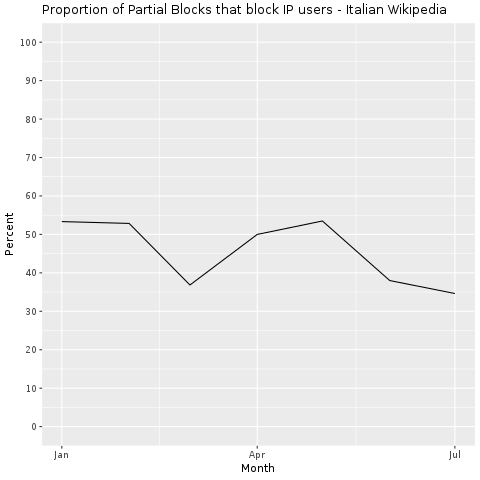

In [34]:
%%R -i it_ips_monthly

it_ips_monthly = data.table(it_ips_monthly);
it_ips_monthly[, log_month := as.Date(log_month)]

g = ggplot(it_ips_monthly[blockee_is_ip == TRUE],
           aes(x = log_month, y = percent)) +
scale_x_date("Month") +
scale_y_continuous("Percent", lim = c(0, 100), breaks = c(0:10)*10) +
ggtitle("Proportion of Partial Blocks that block IP users - Italian Wikipedia") +
geom_line()
ggsave("graphs/itwiki_partial_prop_ip.png",
       plot = g, width = 30, height = 20, units = "cm", dpi = "screen");
g

## Proportion of partial blocks that block namespaces

Similarly to how we counted how many partial blocks where of IP users, we can also count how many partial blocks have at least one namespace set.

In [35]:
it_namespaces_monthly = (partial_blocks.loc[partial_blocks.wiki == 'itwiki']
                         .groupby(['log_month', 'block_num_namespaces'])['wiki']
                         .count().reset_index()
                         .rename(columns = {'wiki' : 'n'}))

it_namespaces_monthly['percent'] = (
    100 * it_namespaces_monthly['n'] /
    it_namespaces_monthly.groupby(['log_month'])['n'].transform('sum'))

In [36]:
it_namespaces_monthly

,log_month,block_num_namespaces,n,percent
0,2019-01-01,0.0,40,100.000000
1,2019-02-01,0.0,52,91.228070
2,2019-02-01,1.0,5,8.771930
3,2019-03-01,0.0,49,76.562500
4,2019-03-01,1.0,12,18.750000
5,2019-03-01,2.0,2,3.125000
6,2019-03-01,3.0,1,1.562500
7,2019-04-01,0.0,19,61.290323
8,2019-04-01,1.0,12,38.709677
9,2019-05-01,0.0,29,74.358974


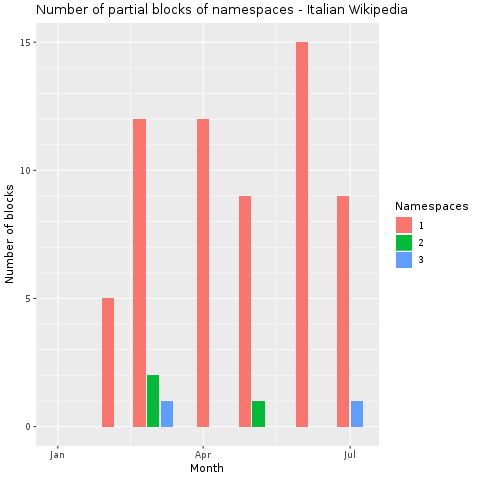

In [37]:
%%R -i it_namespaces_monthly

it_namespaces_monthly = rbind(data.table(it_namespaces_monthly),
                              list('2019-01-01', 1, 0, 0))
it_namespaces_monthly[, log_month := as.Date(log_month)]


g = ggplot(it_namespaces_monthly[block_num_namespaces > 0],
           aes(x = log_month, y = n, fill = factor(block_num_namespaces))) +
scale_x_date("Month") +
scale_y_continuous("Number of blocks", limit = c(0, 15), breaks = c(0:4)*5,
                   minor_breaks = c(0:20)) +
scale_fill_discrete("Namespaces") +
ggtitle("Number of partial blocks of namespaces - Italian Wikipedia") +
geom_col(position = position_dodge2(width = 0.9, preserve = "single"));

ggsave("graphs/itwiki_partial_namespaces.png",
       plot = g, width = 30, height = 20, units = "cm", dpi = "screen");
g

## Number of blocks per month - Italian Wikipedia

Just plotting the total number of partial blocks per month on Italian Wikipedia, for reference.

In [38]:
it_blocks = partial_blocks.loc[partial_blocks.wiki == 'itwiki']
it_counts_monthly = (it_blocks.groupby('log_month')['wiki']
                     .count().reset_index()
                     .rename(columns = {'wiki': 'n'}))

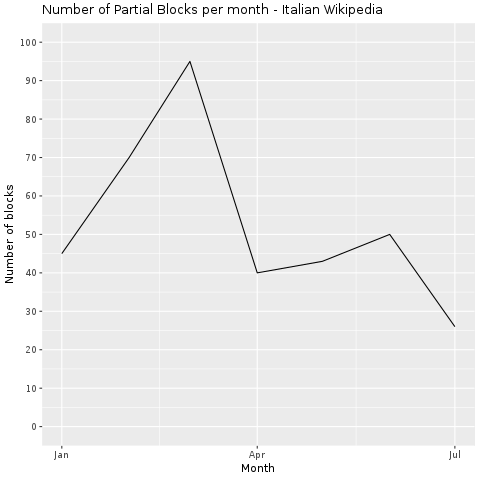

In [39]:
%%R -i it_counts_monthly

it_counts_monthly = data.table(it_counts_monthly);
it_counts_monthly[, log_month := as.Date(log_month)]

g = ggplot(it_counts_monthly,
           aes(x = log_month, y = n)) +
scale_x_date("Month") +
scale_y_continuous("Number of blocks", lim = c(0, 100), breaks = c(0:10)*10) +
ggtitle("Number of Partial Blocks per month - Italian Wikipedia") +
geom_line()
ggsave("graphs/itwiki_partial_per_month.png",
       plot = g, width = 30, height = 20, units = "cm", dpi = "screen");
g

## Distribution of namespaces

For blocks that block a namespace, what is the distribution of namespaces?

In [40]:
from collections import defaultdict

def count_namespaces(df):
    '''
    For the given `pandas.DataFrame` `df` with partial blocks data,
    loop through the log parameters of all blocks, identify if they
    block a namespace and count the number of blocks per namespace.
    '''
    
    ns_counts = defaultdict(int)

    for row in df.itertuples(index = False):
        params = ps.loads(row.log_params.encode('utf-8'), decode_strings=True)
    
        try:     
            restrictions = params['7::restrictions']
            namespaces = restrictions['namespaces']
            for ns in namespaces.values():
                ns_counts[int(ns)] += 1
        except KeyError:
            pass
       
    return(pd.DataFrame(ns_counts.items(), columns = ['namespace', 'count']))

In [41]:
it_ns_counts = count_namespaces(partial_blocks.loc[partial_blocks.wiki == 'itwiki'])

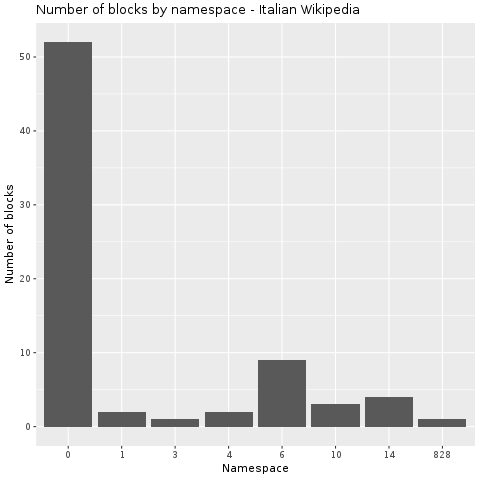

In [42]:
%%R -i it_ns_counts

g = ggplot(it_ns_counts, aes(x = factor(namespace), y = count)) +
ggtitle("Number of blocks by namespace - Italian Wikipedia") +
scale_x_discrete("Namespace") +
scale_y_continuous("Number of blocks") +
geom_col()

ggsave("graphs/itwiki_blocks_per_namespace.png",
       plot = g, width = 30, height = 20, units = "cm", dpi = "screen");
g